In [10]:
# 🧱 Step 1: Imports
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ✅ Step 2: Directory Setup

# Original Kaggle input directory
original_data_dir = "/kaggle/input/cell-images-for-detecting-malaria/cell_images"
print("Folders inside data_dir:", os.listdir(original_data_dir))

# Create a clean working directory
clean_data_dir = "/kaggle/working/clean_data"
os.makedirs(clean_data_dir, exist_ok=True)

# Only copy valid class folders (Parasitized, Uninfected)
for class_name in ["Parasitized", "Uninfected"]:
    src = os.path.join(original_data_dir, class_name)
    dst = os.path.join(clean_data_dir, class_name)
    if os.path.exists(src):
        shutil.copytree(src, dst)

# ✅ Confirm it's clean
print("Clean directory contents:", os.listdir(clean_data_dir))


Folders inside data_dir: ['Uninfected', 'Parasitized', 'cell_images']
Clean directory contents: ['Uninfected', 'Parasitized']


Total Parasitized Images: 13780
Total Uninfected Images: 13780


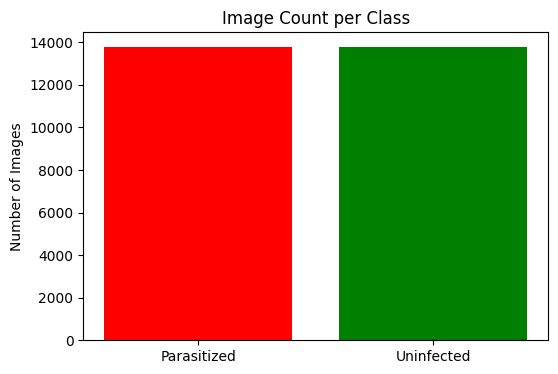

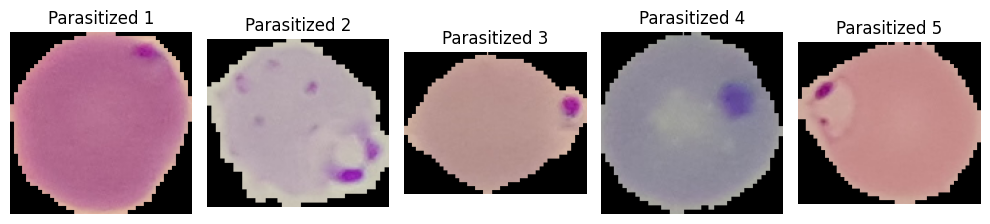

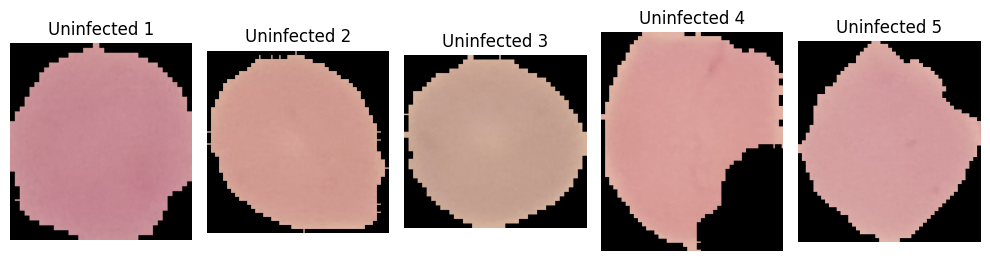

In [2]:
# # Count number of images in each folder
# parasitized_imgs = os.listdir(parasitized_dir)
# uninfected_imgs = os.listdir(uninfected_dir)

# print(f"Total Parasitized Images: {len(parasitized_imgs)}")
# print(f"Total Uninfected Images: {len(uninfected_imgs)}")

# # 📊 Bar plot for class distribution
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6,4))
# plt.bar(['Parasitized', 'Uninfected'], [len(parasitized_imgs), len(uninfected_imgs)], color=['red', 'green'])
# plt.title("Image Count per Class")
# plt.ylabel("Number of Images")
# plt.show()

# # 📷 Show 5 sample images from each class
# import random
# from PIL import Image

# def show_images(image_list, folder, title):
#     plt.figure(figsize=(10, 5))
#     for i, img_file in enumerate(image_list):
#         img_path = os.path.join(folder, img_file)
#         img = Image.open(img_path)
#         plt.subplot(1, 5, i+1)
#         plt.imshow(img)
#         plt.axis('off')
#         plt.title(f'{title} {i+1}')
#     plt.tight_layout()
#     plt.show()

# # Display 5 random parasitized images
# sample_parasitized = random.sample(parasitized_imgs, 5)
# show_images(sample_parasitized, parasitized_dir, "Parasitized")

# # Display 5 random uninfected images
# sample_uninfected = random.sample(uninfected_imgs, 5)
# show_images(sample_uninfected, uninfected_dir, "Uninfected")


In [11]:
# Image dimensions
img_height, img_width = 128, 128
batch_size = 32

# Augmentation for training, only rescaling for validation/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    clean_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    clean_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746377204.190638      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
epochs = 10

print("Model Training Started...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Model Training Started...
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 111s 159ms/step - accuracy: 0.7150 - loss: 0.5571 - val_accuracy: 0.8677 - val_loss: 0.3149
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 156ms/step - accuracy: 0.8869 - loss: 0.2868 - val_accuracy: 0.9060 - val_loss: 0.2369
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.9215 - loss: 0.2159 - val_accuracy: 0.9180 - val_loss: 0.2280
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 156ms/step - accuracy: 0.9351 - loss: 0.1818 - val_accuracy: 0.9080 - val_loss: 0.2657
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.9427 - loss: 0.1690 - val_accuracy: 0.9261 - val_loss: 0.1910
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 156ms/step - accuracy: 0.9423 - loss: 0.1607 - val_accuracy: 0.9356 - val_loss: 0.1721
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.9490 - loss: 0.1398 - val_accuracy: 0.9352 - val_loss: 0.1754
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms

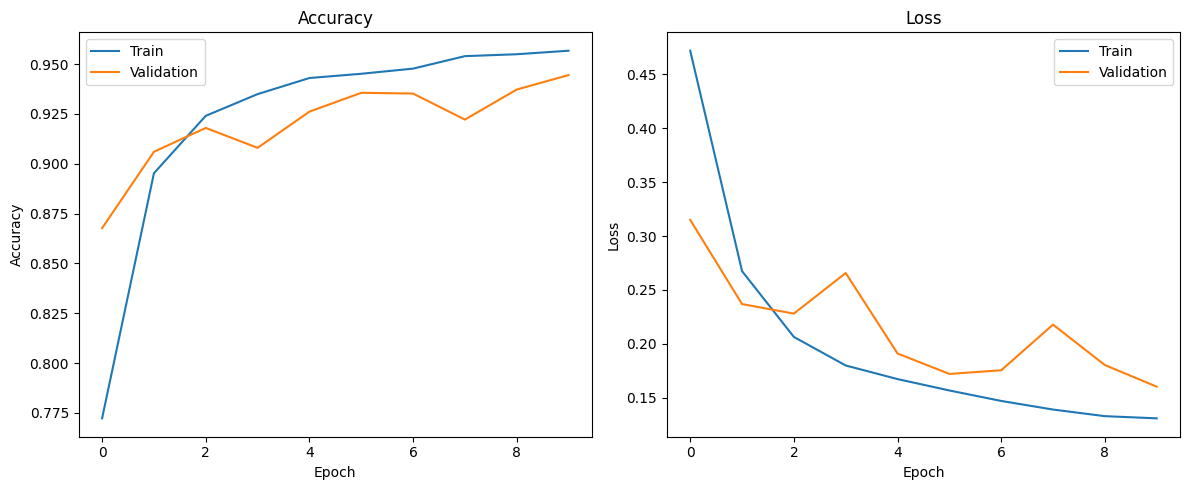

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step


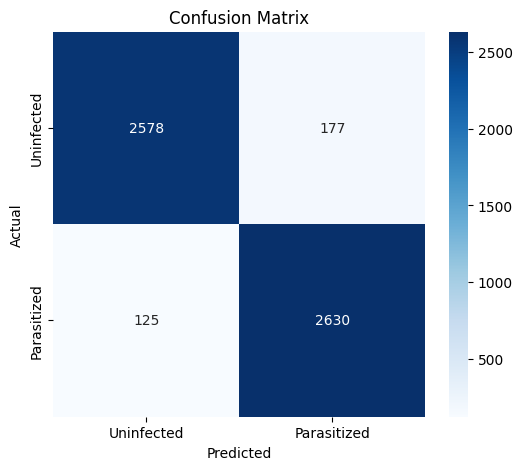

              precision    recall  f1-score   support

  Uninfected       0.95      0.94      0.94      2755
 Parasitized       0.94      0.95      0.95      2755

    accuracy                           0.95      5510
   macro avg       0.95      0.95      0.95      5510
weighted avg       0.95      0.95      0.95      5510



In [16]:
# Predict on validation set
val_generator.reset()
preds = model.predict(val_generator)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: Uninfected


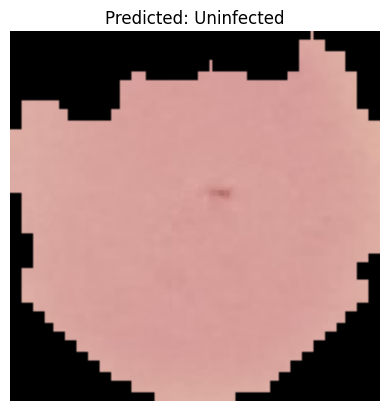

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: Parasitized


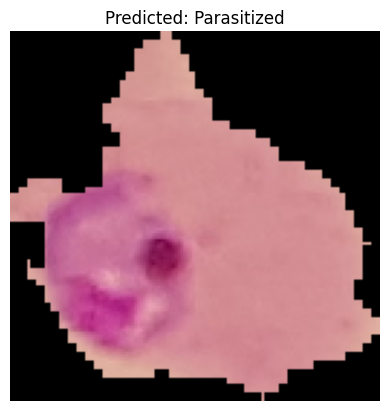

In [24]:
def predict_cell_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    result = "Uninfected" if prediction[0][0] > 0.5 else "Parasitized"
    print(f"Prediction: {result}")

    plt.imshow(img)
    plt.title(f"Predicted: {result}")
    plt.axis('off')
    plt.show()
    
# Example usage:
predict_cell_image("/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png")
predict_cell_image("/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144348_cell_144.png")
